# COVID-19 - Clinical Data to Assess Diagnosis

# What **problem** do we have here? What can we do to help?

The COVID-19 pandemic. Unfortunally we are all aware of it by now. We all know the sad and high number of deaths and the hopeful increasing number of vaccinated people (in some countries).

Seeing as the number of people infected by the virus keeps growing, we need more and more ways of better allocating these patients so as not to overwhelm our health systems.

In this context, brazilian hospital Sírio-Libânes [published a dataset at Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) urging people to take action in predicting the need for ICU beds.

# How was this notebook organized?

In this **Part 1** we'll begin by **checking** and **cleaning** our data. For this, we'll follow these steps:

![data cleaning steps](https://i.imgur.com/1AJyC0O.png)

After that, we'll **analyse** the data as the following image:

![data analysis steps](https://i.imgur.com/MakbgMD.png)

# Where did we get this **data**? What kind of **information** do we have in it?

The data was taken directly from the [Kaggle problem](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) and uploaded to [Github](https://github.com/diascarolina/data-science-bootcamp/blob/main/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true) for easy access.

**From Kaggle:**

> The dataset contains **anonymized data** from Hospital Sírio-Libanês, São Paulo and Brasília. All data were anonymized following the best international practices and recommendations.

> Data has been cleaned and **scaled** by column according to MinMaxScaler to fit between -1 and 1.

_Disclaimer._ It is highly recommended that we apply a scaler to the data only **after** splitting between train and test data (_source:_ [Data Normalization Before or After Splitting a Data Set?](https://www.baeldung.com/cs/data-normalization-before-after-splitting-set)).  But since our data is already scaled, we won't go in too much detail in this aspect.

**From our dataset we have:**

1. Patient demographic information (03 columns)
2. Patient previous grouped diseases (09 columns)
3. Blood results (36 columns)
4. Vital signs (06 columns)

In total there are **54 features**, expanded when pertinent to the _mean, median, max, min, diff and relative diff_, where

- _diff = max - min_
- _relative diff = diff/median_

Furthermore, **our target variable is the ICU** column, in which we have **0** (zero) if that patient did not go to the ICU and **1** (one) if that corresponding patient did go to the ICU.

We also have a column called **Window**. What does this variable mean?

Again, from Kaggle:

> We were careful to include real life cenarios of window of events and available data. Data was obtain and grouped as follows:

- patient
    - patient encounter
    - aggregated by windows in chronological order


Window | Description
:---: | :---:
**0-2**	| From 0 to 2 hours of the admission
**2-4**	| From 2 to 4 hours of the admission
**4-6**	| From 4 to 6 hours of the admission
**6-12** | From 6 to 12 hours of the admission
**Above-12** | Above 12 hours from admission

> Beware **NOT to use the data when the target variable is present**, as it is unknown the order of the event (maybe the target event happened before the results were obtained). They were kept there so we can grow this dataset in other outcomes latter on.

**Examples obtained from Kaggle description:**

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1591620%2Fb1bc424df771a4d2d3b3088606d083e6%2FTimeline%20Example%20Best.png?generation=1594740856017996&alt=media)

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1591620%2F77ca2b4635bc4dd7800e1c777fed9de1%2FTimeline%20Example%20No.png?generation=1594740873237462&alt=media)



# Libraries & Configurations

Remember that this notebook is only used for data cleaning and analysis, so we'll only use libraries related to this task.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# colors definition
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1 = '#F79747'

# charts configs
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
plt.rcParams['mathtext.it'] = 'Arial:italic'

# Data Checking: is everything in its right place?


In [ ]:
data_url = 'https://github.com/diascarolina/data-science-bootcamp/blob/main/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true'

raw_data = pd.read_excel(data_url)

In [ ]:
raw_data.head(15)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.339130,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.4075

Let's check this data.

In [ ]:
def print_data_shape(dataset):
    '''
    Prints the number of rows and columns in a pandas dataframe.

    Input:
    dataset -> a pandas dataframe
    '''
    
    print(f'Number of rows in the dataset: {dataset.shape[0]}')
    print(f'Number of columns in the dataset: {dataset.shape[1]}')

In [ ]:
print_data_shape(raw_data)

Number of rows in the dataset: 1925
Number of columns in the dataset: 231


We have 1925 rows in our dataset. But does this mean that each row represents a patient? Let's check the column ```PATIENT_VISIT_IDENTIFIER```.

In [ ]:
num_unique = len(raw_data['PATIENT_VISIT_IDENTIFIER'].unique())

print(f'Number of unique values in the column PATIENT_VISIT_IDENTIFIER: {num_unique}')

Number of unique values in the column PATIENT_VISIT_IDENTIFIER: 385


With the cell above, we see that we have 385 unique values in the ```PATIENT_VISIT_IDENTIFIER``` columns. This is exactly the number of rows, 1925, divided by 5. This means we only have 385 patients in this dataset, each one represented by 5 rows. Each of these 5 rows for a patient correspond with the ```WINDOW``` column.

In [ ]:
raw_data['WINDOW'].unique()

array(['0-2', '2-4', '4-6', '6-12', 'ABOVE_12'], dtype=object)

We can see that the ```WINDOW``` column is divided into the following categories:

- 0-2
- 2-4
- 4-6
- 6-12
- ABOVE_12

Each of these categories represent a time window with how many hours did it take for the patient to go the ICU. For example, if a patient went to the ICU between 2 and 6 of being admited, then we would have the following data:

**WINDOW** | **ICU**
:---:|:---:
0-2 | 0
2-4 | 1
4-6 | 1
6-12 | 1
ABOVE_12 | 1

**Obs.** All of this information is also present in the [Kaggle problem page](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

# Missing Values & Data Preparation

Just from taking a quick look at the data we can see we have some missing values, specially on the columns where we have continuous values, ranging from the column ```ALBUMIN_MEDIAN``` to ```OXYGEN_SATURATION_DIFF_REL```. These represent the measurements from the patient and said measurements are not taken constantly, as explained bellow (also found at the [Kaggle problem page](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)).

> **Problem:** One of the major challenges of working with health care data is that the sampling rate varies across different type of measurements. For instance, vital signs are sampled more frequently (usually hourly) than blood labs (usually daily).

> **Tips & Tricks:** It is reasonable to assume that a patient who does not have a measurement recorded in a time window is clinically stable, potentially presenting vital signs and blood labs similar to neighboring windows. Therefore, one may fill the missing values using the next or previous entry. Attention to multicollinearity and zero variance issues in this data when choosing your algorithm.

With this in mind, we'll use this approach of filling the missing values using the next or the previous entry. For this, we'll create a function that fills the missing values for the continuous variables in the dataset. These variables are already aggregated for us in the columns ```[13:-2]```.

The methods used will be the "forward fill"and the "backfill".

But first let's check how many missing values we have in the whole dataset.

In [ ]:
def check_missing_values(dataset):
    '''
    Function that prints the number of missing values in a dataframe, together
    with its percentage against the total number of values in the dataframe.

    Input:
    dataset -> a pandas dataframe
    
    Output:
    A print statement.
    '''

    number_of_null_values = dataset.isnull().values.sum()

    # this is just the number of rows times the number of columns
    total_values_in_dataset = dataset.shape[0] * dataset.shape[1]

    percentage = number_of_null_values / total_values_in_dataset * 100

    print(f'We have {number_of_null_values} null values in this dataset.')
    print(f'This represents {round(percentage, 2)}% of the total number of values in the dataset')

In [ ]:
check_missing_values(raw_data)

We have 223863 null values in this dataset.
This represents 50.34% of the total number of values in the dataset


We could try and visualize graphically the missing values and its distribution in the dataset, using a library like [missingno](https://github.com/ResidentMario/missingno). But since we have so many columns to visualize, it would not be a very good visualization.

Bellow we define the function to fill the values in the continous variables using the previous or the next observation in the dataset.

In [ ]:
def fill_dataset(data):
    '''
    Function that fills the missing values in the dataset with the methods 'bfill'
    and 'ffill'. This substitution is only applied in the continuous variables.
    
    Input:
    data -> a pandas dataframe
    
    Output:
    filled_data -> a pandas dataframe without missing values in the continuous variables
    '''
    
    # select the columns with the continuous variables
    columns_continuous_features = data.iloc[:, 13:-2].columns
    
    # group the dataset per patient and we substitute the missing values
    # using the 'bfill' and 'ffill' methods for each patient
    continuous_features = data.groupby('PATIENT_VISIT_IDENTIFIER',
                                       as_index = False)[columns_continuous_features].fillna(method = 'bfill').fillna(method = 'ffill')
    
    categorical_features = data.iloc[:, :13]
    output_data = data.iloc[:, -2:]
    
    filled_data = pd.concat([categorical_features, continuous_features, output_data],
                            ignore_index = True,
                            axis = 1)
    
    filled_data.columns = data.columns
    
    return filled_data

In [ ]:
data = raw_data.copy()
filled_data = fill_dataset(data)
filled_data.head(10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.339130,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27

So now, by just taking a look at the data above, we see that the missing values in the continuous variables were filled.

Let's check if we have any other null values in the other columns.

In [ ]:
check_missing_values(filled_data)

We have 45 null values in this dataset.
This represents 0.01% of the total number of values in the dataset


We can see we still have some missing values, but significantly less than before. We can simply go ahead and remove these ones, since they represent only a smal percentage of the dataset and are probably from errors in the data.

We can also go ahead and remove the observations in which the admitted patients went to the ICU at window 0-2. This is also a recommendation from the hospital itself, regarding machine learning model and the usefulness of the data:

**The earlier, the better!**

> **Problem:** Early identification of those patients who will develop an adverse course of illness (and need intensive care) is a key for an appropriate treatment (saving lives) and to managing beds and resources.

> **Tips & Tricks:** _Whereas a predictive model using all time windows will probably yield a greater accuracy, a nice model using only the first (0-2) is likely to be more clinically relevant._

We also have:

> [...] patients that went to the ICU on 0-2 window have no available data for predicting, therefore should also be excluded from the sample.

So let's do that.



In [ ]:
# check the number of 1's in the 0-2 window
pd.crosstab(filled_data['WINDOW'], filled_data['ICU'])

ICU,0,1
WINDOW,,
0-2,353,32
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


As seen above, we have **32 observations in which the patient went to the ICU at the 0-2 window**. So we'll discard these 32 patients from our dataset.

In [ ]:
# let's get only the patients which did not went to the ICU in the first two hours of admission
to_be_removed = filled_data.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
filled_data = filled_data.query("PATIENT_VISIT_IDENTIFIER not in @to_be_removed")
# drop the remaining missing values
filled_data = filled_data.dropna()

filled_data.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27272

In [ ]:
check_missing_values(filled_data)

We have 0 null values in this dataset.
This represents 0.0% of the total number of values in the dataset


In [ ]:
print_data_shape(filled_data)

Number of rows in the dataset: 1760
Number of columns in the dataset: 231


Now, we'll group the rows by patient to obtain a dataset where each row represents only one patient, instead of 5 rows per patient.

In [ ]:
def prepare_window(rows):
    '''
    Clean the "WINDOW" row in the dataframe.
    '''

    if(np.any(rows['ICU'])):
       rows.loc[rows['WINDOW'] == '0-2', 'ICU'] = 1
    # return the WINDOW column for the first two hours
    return rows.loc[rows['WINDOW'] == '0-2']


# group the data by patient and apply the function above
clean_data = filled_data.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)

# change the AGE_PERCENTIL column to a 'category' type
clean_data.AGE_PERCENTIL = clean_data.AGE_PERCENTIL.astype('category').cat.codes

clean_data.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

We can go ahead and drop the column ```WINDOW``` since we now have only one value in it: ```0-2```.  We'll also drop the ```PATIENT_VISIT_IDENTIFIER``` since we don't need this information in order to predict the ICU admission.

In [ ]:
clean_data = clean_data.drop(['WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis = 1)

In [ ]:
check_missing_values(clean_data)

We have 0 null values in this dataset.
This represents 0.0% of the total number of values in the dataset


In [ ]:
print_data_shape(clean_data)

Number of rows in the dataset: 352
Number of columns in the dataset: 229


Comparing to the previous dataframe, we now reduced our information from 1760 rows to only 352!

With this new and clean dataset, we'll take a closer look at the variables in order to reduce the large number of columns and explore these features. Furthermore, seeing as we have many features that were created from a single variable, we have to address them and check their correlation against each other. This helps us in reducing the risk of overfitting our machine learning model.

For the variables pertaining to the blood results and vital signs, they were expanded by the mean, median, max, min, diff and relative diff. Where ```diff = max - min``` and ```relative diff = diff/median```.


In [ ]:
# let's check our data again
clean_data.head()

,,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
2,10,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.978029,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
3,15,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,...,-0.978029,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,20,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,...,-1.000000,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776

To check the highly correlated columns, we first declare a function that checks the correlation between each variable in the whole dataset and then it removes the ones that pass a certain threshold.

In [ ]:
def remove_corr_var(data, threshold = 0.95):
    '''
    Given a dataset, this function calculates the correlation between the
    variable and return a new dataset with only the variable with a correlation
    below a certain threshold.

    Input:
    data -> a pandas dataframe
    threshold -> a number (usually between 0 and 1) used as a cutoff for the 
                 correlation, default = 0.95
    '''

    matrix_corr = data.iloc[:,4:-2].corr().abs()
    matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k = 1).astype(np.bool))
    to_remove = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > threshold)]
    return data.drop(to_remove, axis = 1)

In [ ]:
final_data = remove_corr_var(clean_data)

In [ ]:
final_data.head()

,,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_MEDIAN,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,-0.932246,...,-1.0,0.363636,-1.0,-0.540721,-1.0,-0.518519,-1.0,0.939394,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
2,10,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.399199,-1.0,-0.703704,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,-0.961262,1
3,15,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.564753,-1.0,-0.777778,-1.0,0.939394,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,20,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.457944,-1.0,-0.592593,-1.0,0.939394,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,-0.980333,0
5,25,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.292390,-1.0,-0.666667,-1.0,0.939394,-1.0,0.345679,-1.0,0.

In [ ]:
print_data_shape(final_data)

Number of rows in the dataset: 352
Number of columns in the dataset: 99


So now we have a dataset with 352 rows, one for each patient, and 99 columns. From these 99 columns, 98 are variables and 1 is the target, the ICU column.

# Data Analysis

Now we'll take a closer look at some features to check their distribution and whether or not they are balanced in order to be used in a machine learning model. If they are highly unbalanced, it could create a problem for the modelling part.

In [ ]:
# remembering our dataframe
final_data.head()

,,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_MEDIAN,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,-0.932246,...,-1.0,0.363636,-1.0,-0.540721,-1.0,-0.518519,-1.0,0.939394,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
2,10,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.399199,-1.0,-0.703704,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,-0.961262,1
3,15,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.564753,-1.0,-0.777778,-1.0,0.939394,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,20,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.457944,-1.0,-0.592593,-1.0,0.939394,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,-0.980333,0
5,25,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,-0.959849,...,-1.0,0.363636,-1.0,-0.292390,-1.0,-0.666667,-1.0,0.939394,-1.0,0.345679,-1.0,0.

We have 03 patient demographic information variables: ```AGE_ABOVE65```, ```AGE_PERCENTIL``` and ```GENDER```. Let's take a look at them together with the ```ICU``` column, our target variable. For reference, we can also take a look at the other continuous variables.

## Patient Demographic Information

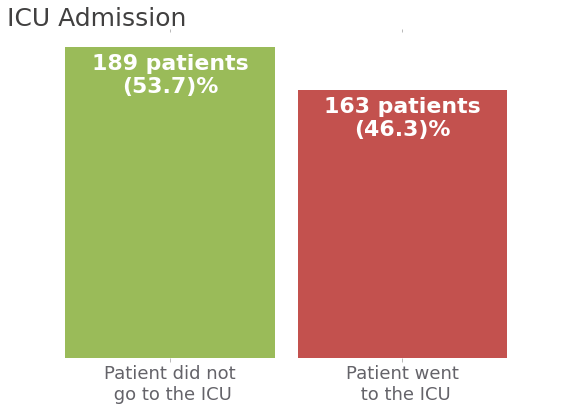

In [ ]:
color = [GREEN2, RED1]
ax = final_data['ICU'].value_counts().plot(kind = 'bar',
                                           color = color,
                                           figsize = (10, 6),
                                           width = 0.9)

ax.tick_params(color = 'darkgrey', bottom = 'off')

ax.tick_params(axis = 'both',
               which = 'both',
               bottom = 'off',
               top = 'off',
               labelbottom = 'off',
               right = 'off',
               left = 'off',
               labelleft = 'off')

sns.despine(left = True, bottom = True)
ax.set_xticklabels(['Patient did not\n go to the ICU', 'Patient went\n to the ICU'],
                   fontsize = 18, color = GRAY4)

ax.get_yaxis().set_visible(False)
plt.xticks(rotation = 0)
plt.title('ICU Admission', fontsize = 25, loc = 'left', color = GRAY2)

perc_not_icu = round(len(final_data[final_data['ICU'] != 1]) /  len(final_data) * 100, 1)
perc_icu = round(len(final_data[final_data['ICU'] == 1]) /  len(final_data) * 100, 1)
labels = [str(len(final_data[final_data['ICU'] == 0])) + ' patients\n(' + str(perc_not_icu) + ')%',
          str(len(final_data[final_data['ICU'] == 1])) + ' patients\n(' + str(perc_icu) + ')%']
          
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2,
            height-30,
            label,
            ha = 'center',
            va = 'bottom',
            color = 'white',
            fontsize = 22,
            fontweight = 'bold')

plt.show()

We don't have a hard threshold for when to consider our data unbalanced, but [some sources](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) indicate that we can begin to consider our data **unbalanced** when the difference between the classes is **above 20%**. Here in our case, the difference is only **7.4%**, so we'll consider our **target variable balanced**.

In [ ]:
#final_data.to_csv('final_data.csv', index = False)
#from google.colab import files
#files.download('final_data.csv')

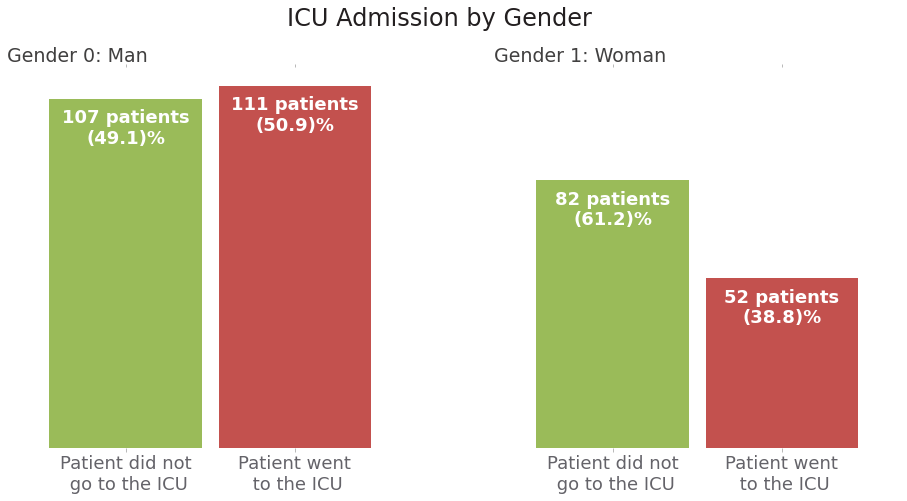

In [ ]:
color = [GREEN2, RED1]

fig, axes = plt.subplots(1, 2, sharey = True, figsize = (16, 7))

final_data[final_data.GENDER == 0].ICU.value_counts().sort_values(ascending = True).plot(kind = 'bar',
                                                           ax = axes[0],
                                                           color = color,
                                                           width = 0.9)
axes[0].set_title('Gender 0: Man', loc = 'left', fontsize = 19, color = GRAY2)

final_data[final_data.GENDER == 1].ICU.value_counts().plot(kind = 'bar',
                                                           ax = axes[1],
                                                           color = color,
                                                           width = 0.9)
axes[1].set_title('Gender 1: Woman', loc = 'left', fontsize = 19, color = GRAY2)

sns.despine(left = True, bottom = True)

for i in [0, 1]:
    axes[i].tick_params(color = 'darkgrey', bottom = 'off')
    axes[i].tick_params(axis = 'both',
                        which = 'both',
                        bottom = 'off',
                        top = 'off',
                        labelbottom = 'off',
                        right = 'off',
                        left = 'off',
                        labelleft = 'off')
    axes[i].set_xticklabels(['Patient did not\n go to the ICU', 'Patient went\n to the ICU'],
                        fontsize = 18, color = GRAY4, rotation = 0)
    axes[i].get_yaxis().set_visible(False)

plt.suptitle('ICU Admission by Gender', fontsize = 24, color = GRAY1, y = 1)

# Code for chart annotation

perc_not_icu_0 = round(final_data[final_data.GENDER == 0].ICU.value_counts()[0] /  len(final_data[final_data.GENDER == 0]) * 100, 1)
perc_icu_0 = round(final_data[final_data.GENDER == 0].ICU.value_counts()[1] /  len(final_data[final_data.GENDER == 0]) * 100, 1)
labels = [str(final_data[final_data.GENDER == 0].ICU.value_counts()[0]) + ' patients\n(' + str(perc_not_icu_0) + ')%',
          str(final_data[final_data.GENDER == 0].ICU.value_counts()[1]) + ' patients\n(' + str(perc_icu_0) + ')%']
          
rects = axes[0].patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axes[0].text(rect.get_x() + rect.get_width() / 2,
            height-15,
            label,
            ha = 'center',
            va = 'bottom',
            color = 'white',
            fontsize = 18,
            fontweight = 'bold')
    
perc_not_icu_1 = round(final_data[final_data.GENDER == 1].ICU.value_counts()[0] /  len(final_data[final_data.GENDER == 1]) * 100, 1)
perc_icu_1 = round(final_data[final_data.GENDER == 1].ICU.value_counts()[1] /  len(final_data[final_data.GENDER == 1]) * 100, 1)
labels = [str(final_data[final_data.GENDER == 1].ICU.value_counts()[0]) + ' patients\n(' + str(perc_not_icu_1) + ')%',
          str(final_data[final_data.GENDER == 1].ICU.value_counts()[1]) + ' patients\n(' + str(perc_icu_1) + ')%']
          
rects = axes[1].patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axes[1].text(rect.get_x() + rect.get_width() / 2,
            height-15,
            label,
            ha = 'center',
            va = 'bottom',
            color = 'white',
            fontsize = 18,
            fontweight = 'bold')

plt.show()

Here we can immediately see some interesting facts:

-


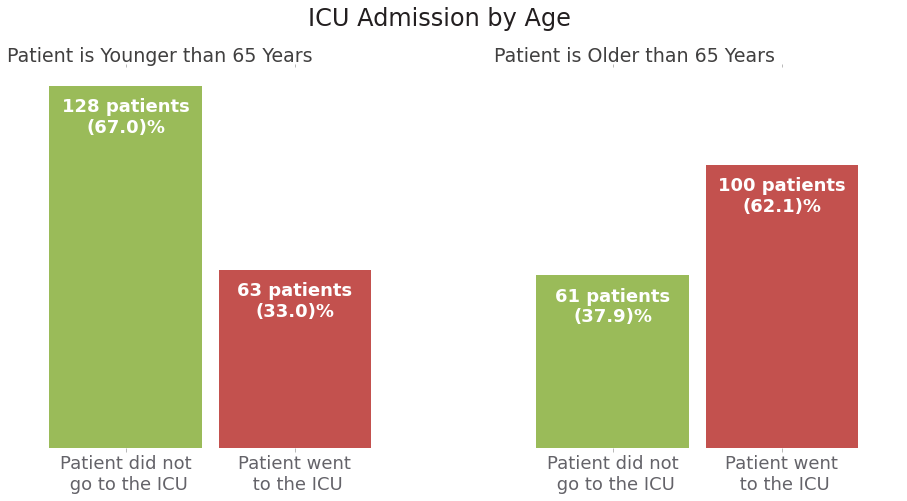

In [ ]:
color = [GREEN2, RED1]

fig, axes = plt.subplots(1, 2, sharey = True, figsize = (16, 7))

final_data[final_data.AGE_ABOVE65 == 0].ICU.value_counts().plot(kind = 'bar',
                                                           ax = axes[0],
                                                           color = color,
                                                           width = 0.9)
axes[0].set_title('Patient is Younger than 65 Years', loc = 'left', fontsize = 19, color = GRAY2)

final_data[final_data.AGE_ABOVE65 == 1].ICU.value_counts().sort_values(ascending = True).plot(kind = 'bar',
                                                           ax = axes[1],
                                                           color = color,
                                                           width = 0.9)
axes[1].set_title('Patient is Older than 65 Years', loc = 'left', fontsize = 19, color = GRAY2)

sns.despine(left = True, bottom = True)

for i in [0, 1]:
    axes[i].tick_params(color = 'darkgrey', bottom = 'off')
    axes[i].tick_params(axis = 'both',
                        which = 'both',
                        bottom = 'off',
                        top = 'off',
                        labelbottom = 'off',
                        right = 'off',
                        left = 'off',
                        labelleft = 'off')
    axes[i].set_xticklabels(['Patient did not\n go to the ICU', 'Patient went\n to the ICU'],
                        fontsize = 18, color = GRAY4, rotation = 0)
    axes[i].get_yaxis().set_visible(False)

plt.suptitle('ICU Admission by Age', fontsize = 24, color = GRAY1, y = 1)

# Code for chart annotation

per_not_icu_0 = round(final_data[final_data.AGE_ABOVE65 == 0].ICU.value_counts()[0] /  len(final_data[final_data.AGE_ABOVE65 == 0]) * 100, 1)
per_icu_0 = round(final_data[final_data.AGE_ABOVE65 == 0].ICU.value_counts()[1] /  len(final_data[final_data.AGE_ABOVE65 == 0]) * 100, 1)
labels = [str(final_data[final_data.AGE_ABOVE65 == 0].ICU.value_counts()[0]) + ' patients\n(' + str(per_not_icu_0) + ')%',
          str(final_data[final_data.AGE_ABOVE65 == 0].ICU.value_counts()[1]) + ' patients\n(' + str(per_icu_0) + ')%']
          
rects = axes[0].patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axes[0].text(rect.get_x() + rect.get_width() / 2,
            height-18,
            label,
            ha = 'center',
            va = 'bottom',
            color = 'white',
            fontsize = 18,
            fontweight = 'bold')
    
per_not_icu_1 = round(final_data[final_data.AGE_ABOVE65 == 1].ICU.value_counts()[0] /  len(final_data[final_data.AGE_ABOVE65 == 1]) * 100, 1)
per_icu_1 = round(final_data[final_data.AGE_ABOVE65 == 1].ICU.value_counts()[1] /  len(final_data[final_data.AGE_ABOVE65 == 1]) * 100, 1)
labels = [str(final_data[final_data.AGE_ABOVE65 == 1].ICU.value_counts()[0]) + ' patients\n(' + str(per_not_icu_1) + ')%',
          str(final_data[final_data.AGE_ABOVE65 == 1].ICU.value_counts()[1]) + ' patients\n(' + str(per_icu_1) + ')%']
          
rects = axes[1].patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axes[1].text(rect.get_x() + rect.get_width() / 2,
            height-18,
            label,
            ha = 'center',
            va = 'bottom',
            color = 'white',
            fontsize = 18,
            fontweight = 'bold')

plt.show()

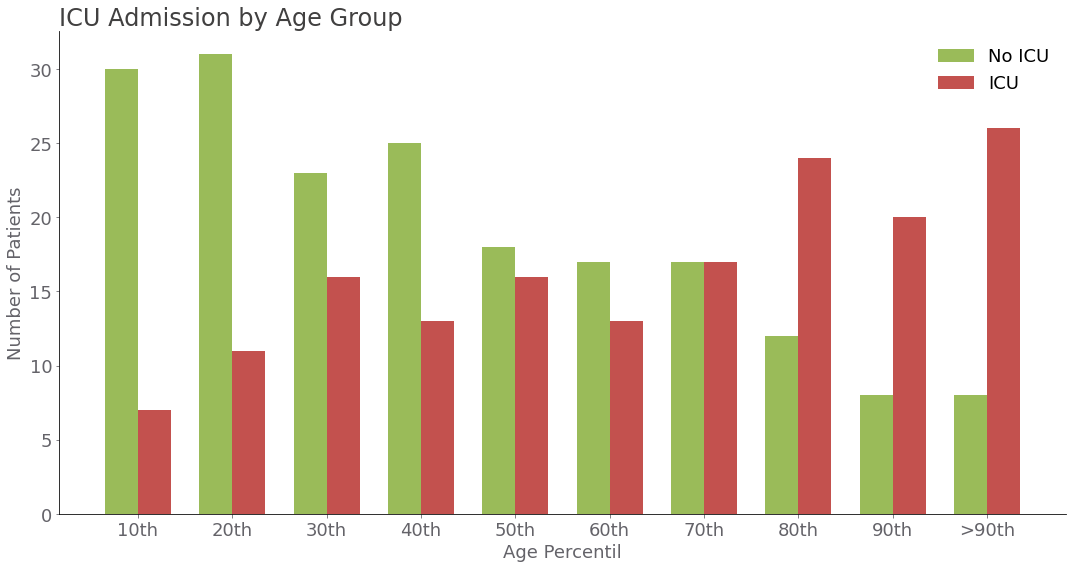

In [ ]:
label_names = ['10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th', '90th', '>90th']
label_codes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

not_icu = []
icu = []
for code in label_codes:
    not_icu.append(final_data[final_data.AGE_PERCENTIL == code].ICU.value_counts()[0])
    icu.append(final_data[final_data.AGE_PERCENTIL == code].ICU.value_counts()[1])

x = np.arange(len(label_names))
width = 0.35

fig, ax = plt.subplots(figsize = (15, 8))
rects1 = ax.bar(x - width/2, not_icu, width, label = 'No ICU', color = GREEN2)
rects2 = ax.bar(x + width/2, icu, width, label = 'ICU', color = RED1)

ax.set_ylabel('Number of Patients', fontsize = 18)
ax.set_xlabel('Age Percentil', fontsize = 18, color = GRAY4)
ax.set_title('ICU Admission by Age Group', loc = 'left', fontsize = 24, color = GRAY2)
ax.set_xticks(x)
ax.set_xticklabels(label_names, fontsize = 18, color = GRAY4, rotation = 0)
ax.yaxis.label.set_color(GRAY4)
ax.tick_params(axis = 'both', colors = GRAY4)
ax.tick_params(axis = 'y', labelsize = 18)
ax.set_xticklabels(label_names)
plt.legend(fontsize = 18, frameon = False)
sns.despine()

fig.tight_layout()

plt.show()

## Patient Previous Grouped Diseases

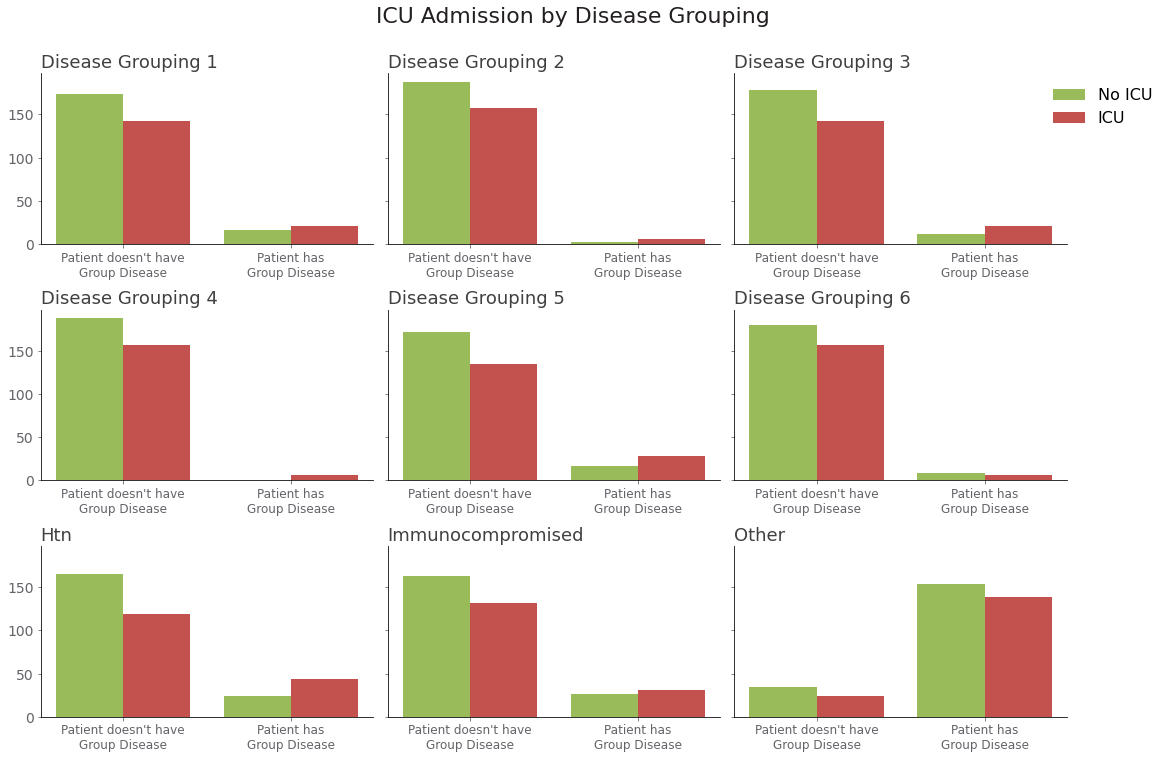

In [ ]:
diseases = {
    'DISEASE GROUPING 1': {'not_icu': [], 'icu': []},
    'DISEASE GROUPING 2': {'not_icu': [], 'icu': []},
    'DISEASE GROUPING 3': {'not_icu': [], 'icu': []},
    'DISEASE GROUPING 4': {'not_icu': [], 'icu': []},
    'DISEASE GROUPING 5': {'not_icu': [], 'icu': []},
    'DISEASE GROUPING 6': {'not_icu': [], 'icu': []},
    'HTN': {'not_icu': [], 'icu': []},
    'IMMUNOCOMPROMISED': {'not_icu': [], 'icu': []},
    'OTHER': {'not_icu': [], 'icu': []}
    }
color = [GREEN2, RED1]

label_names = ['Patient doesn\'t have\nGroup Disease', 'Patient has\nGroup Disease']

for disease in diseases.keys():
    for num in [0, 1]:
        diseases[disease]['not_icu'].append(final_data[final_data[disease] == num].ICU.value_counts()[0])
        diseases[disease]['icu'].append(final_data[final_data[disease] == num].ICU.value_counts()[1])

x = np.arange(len(label_names))
width = 0.40

ax = [0, 1, 2, 3, 4, 5, 6, 7, 8]
fig, ((ax[0], ax[1], ax[2]), (ax[3], ax[4], ax[5]), (ax[6],ax[7], ax[8])) = plt.subplots(3, 3, sharey = True, figsize=(16, 10))

for i in [0, 1, 2, 3, 4, 5, 6, 7, 8]:
    disease = list(diseases.keys())[i]
    ax[i].bar(x - width/2, diseases[disease]['not_icu'], width, label = 'No ICU', color = GREEN2)
    ax[i].bar(x + width/2, diseases[disease]['icu'], width, label = 'ICU', color = RED1)
    #ax[i].set_ylabel('Number of Patients', fontsize = 16)
    ax[i].set_title(disease.title(), loc = 'left', fontsize = 18, color = GRAY2)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(label_names, fontsize = 12, color = GRAY4, rotation = 0)
    ax[i].yaxis.label.set_color(GRAY4)
    ax[i].tick_params(axis = 'both', colors = GRAY4)
    ax[i].tick_params(axis = 'y', labelsize = 14)
    ax[i].set_xticklabels(label_names)

ax[2].legend(fontsize = 16, frameon = False, loc = 'upper right', bbox_to_anchor = (1.3, 1.0))
sns.despine()
plt.suptitle('ICU Admission by Disease Grouping', color = GRAY1, fontsize = 22, y = 1.05)
fig.tight_layout()

plt.show()

## Vital Signs

We'll use the mean of the vital signs columns.

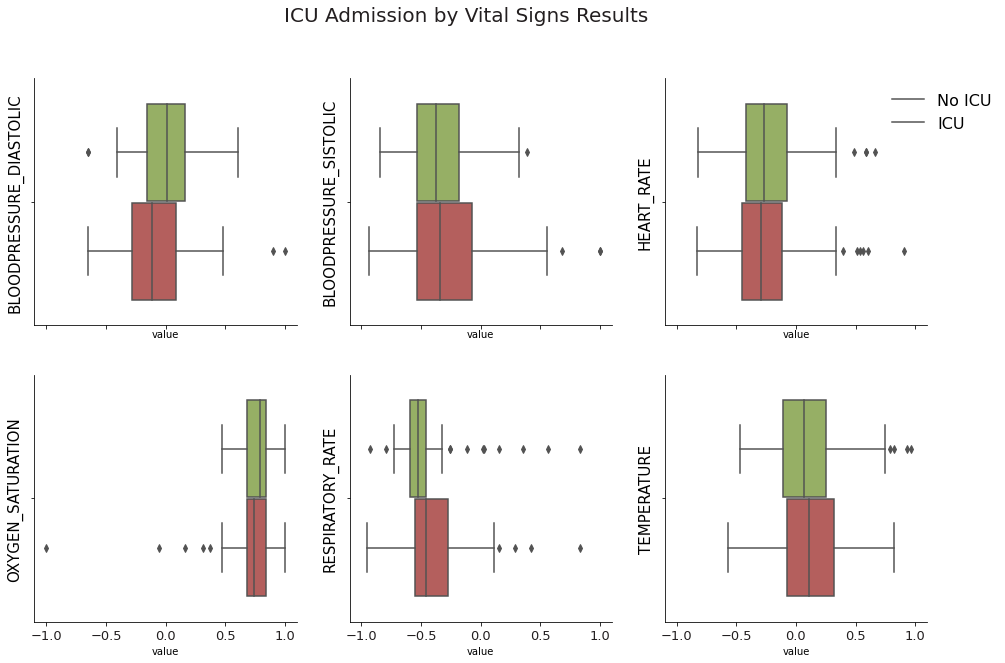

In [ ]:
columns = ['BLOODPRESSURE_DIASTOLIC_MEAN', 'BLOODPRESSURE_SISTOLIC_MEAN',
            'HEART_RATE_MEAN', 'OXYGEN_SATURATION_MEAN',
            'RESPIRATORY_RATE_MEAN', 'TEMPERATURE_MEAN', 'ICU']

ax = [0, 1, 2, 3, 4, 5]
fig, ((ax[0], ax[1], ax[2]), (ax[3], ax[4], ax[5])) = plt.subplots(nrows = 2,
                                                                   ncols = 3,
                                                                   sharex = True,
                                                                   figsize = (16, 10))

for i in [0, 1, 2, 3, 4, 5]:
    column = columns[i]
    temp = final_data.reset_index()[[column, 'ICU']]
    mdf = pd.melt(temp, id_vars = ['ICU'], var_name = [column[:-5]])
    sns.boxplot(x = 'value', y = column[:-5], hue = 'ICU', data = mdf, palette = color, ax = ax[i])
    ax[i].set_yticklabels([])
    ax[i].set_ylabel(column[:-5], fontsize = 15)
    ax[i].legend([],[], frameon = False)
    for j in ax[i].get_xticklabels():
        j.set_fontsize(13)
        j.set_color(GRAY1)
sns.despine()
plt.suptitle('ICU Admission by Vital Signs Results', fontsize = 20, color = GRAY1)
ax[2].legend(['No ICU', 'ICU'], fontsize = 16, frameon = False, loc = 'upper right', bbox_to_anchor = (1.3, 1.0))
plt.show()